In [1]:
from weavepy import *

In [2]:
# Parameters
## Climate
climate_variable = "TA"
climate_variable_comparison = '<=' # '<', '<=', '>', or '>='
climate_variable_threshold = 5 # Number in units of variable
## Energy 
energy_variable = "SPV"
energy_variable_comparison = '<' # '<', '<=', '>', or '>='
energy_variable_threshold = 0.05 # Number in units of variable
## Temporal aggregation
aggregation_frequency = "D"
aggregation_function = "mean"
## Selection
country = "FR"
models = ["ERA5"]
scenarios = []
technos = ["NA", "60", "30"]

In [3]:
%%time 
climate_var = get_data(climate_variable, 42, 
                             [country], technos, models, scenarios,
                             aggregation_frequency, aggregation_function,)

79it [00:04, 19.69it/s]

CPU times: user 3.41 s, sys: 901 ms, total: 4.31 s
Wall time: 4.42 s


In [4]:
%%time 
energy_var = get_data(energy_variable, 42, 
                             [country], technos, models, scenarios,
                             aggregation_frequency, aggregation_function,)

79it [00:03, 23.33it/s]

CPU times: user 3.18 s, sys: 711 ms, total: 3.9 s
Wall time: 3.91 s


In [5]:
data = xr.merge([climate_var.squeeze("tech"), energy_var.squeeze("tech")], compat = "override")

In [6]:
# Identify problematic days
climate_days = identify_pb_days(data[climate_variable], climate_variable_comparison, climate_variable_threshold).rename("climate_event")
energy_days = identify_pb_days(data[energy_variable], energy_variable_comparison, energy_variable_threshold).rename("energy_event")
compound_days = (climate_days & energy_days).rename("compound_event")

In [7]:
# Identify events
climate_events, energy_events, compound_events = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for a, s in tqdm([(a, s) for a in data.model.values for s in data.scenario.values]):
    climate_events = pd.concat([climate_events, identify_events(climate_days.sel(model = a).sel(scenario = s), model = a, country = country, scenario = s)])
    energy_events = pd.concat([energy_events, identify_events(energy_days.sel(model = a).sel(scenario = s), model = a, country = country, scenario = s)])
    compound_events = pd.concat([compound_events, identify_events(compound_days.sel(model = a).sel(scenario = s), model = a, country = country, scenario = s)])

100%|██████████| 1/1 [00:27<00:00, 27.16s/it]


In [8]:
# Compute number of events per year
N_climate_events = climate_events.groupby(["model", "scenario", "country", "year"]).eventID.nunique().reset_index()
N_energy_events = energy_events.groupby(["model", "scenario", "country", "year"]).eventID.nunique().reset_index()
N_compound_events = compound_events.groupby(["model", "scenario", "country", "year"]).eventID.nunique().reset_index()

Text(0.5, 1.0, 'Compound events')

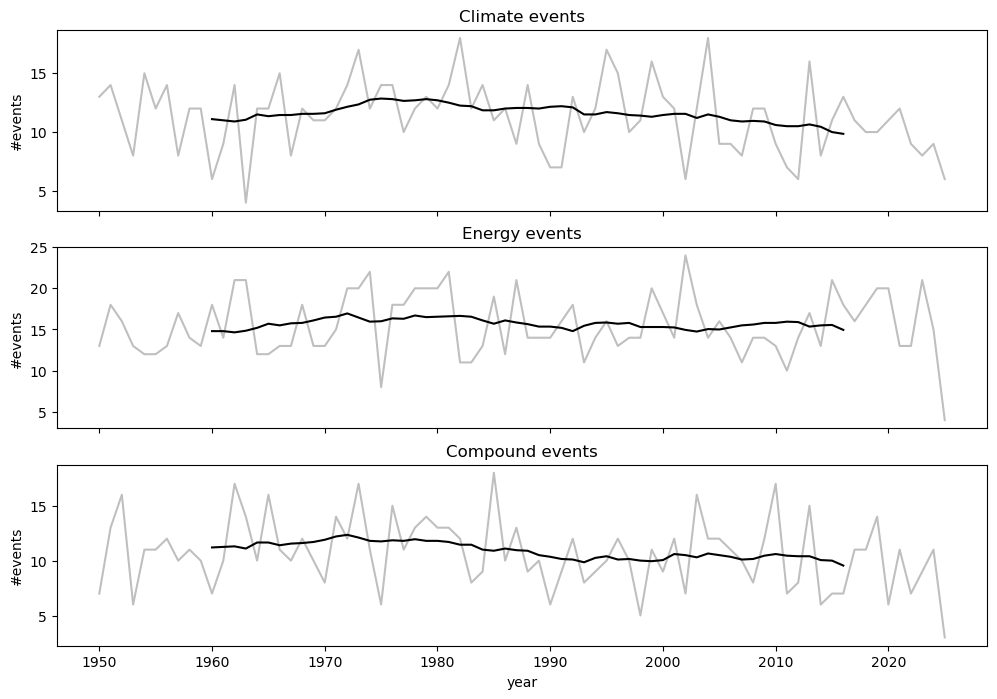

In [9]:
fig, axs = plt.subplots(3, figsize = [12, 8], sharex = True) # TODO: Rolling mean
for i, N in enumerate([N_climate_events, N_energy_events, N_compound_events]):
    for scenario in N_climate_events.scenario.unique():
        for model in N_climate_events.model.unique():
            N2plot = N[(N.scenario == scenario) & (N.model == model)].set_index("year")
            # Raw data
            N2plot.eventID.plot(ax = axs[i], alpha = 0.25, 
                                c = scenario_colors[scenario], linestyle = model_linestyles[model])
            #axs[i].plot(N2plot.year, N2plot.eventID, alpha = 0.5,
            #            c = scenario_colors[scenario], linestyle = model_linestyles[model])
            # Running mean
            Nroll = N2plot.eventID.rolling(20, center = True).mean()
            Nroll.plot(ax = axs[i], 
                    c = scenario_colors[scenario], linestyle = model_linestyles[model])
    axs[i].set_ylabel("#events")
axs[0].set_title("Climate events")
axs[1].set_title("Energy events")
axs[2].set_title("Compound events")

(0.0, 10.0)

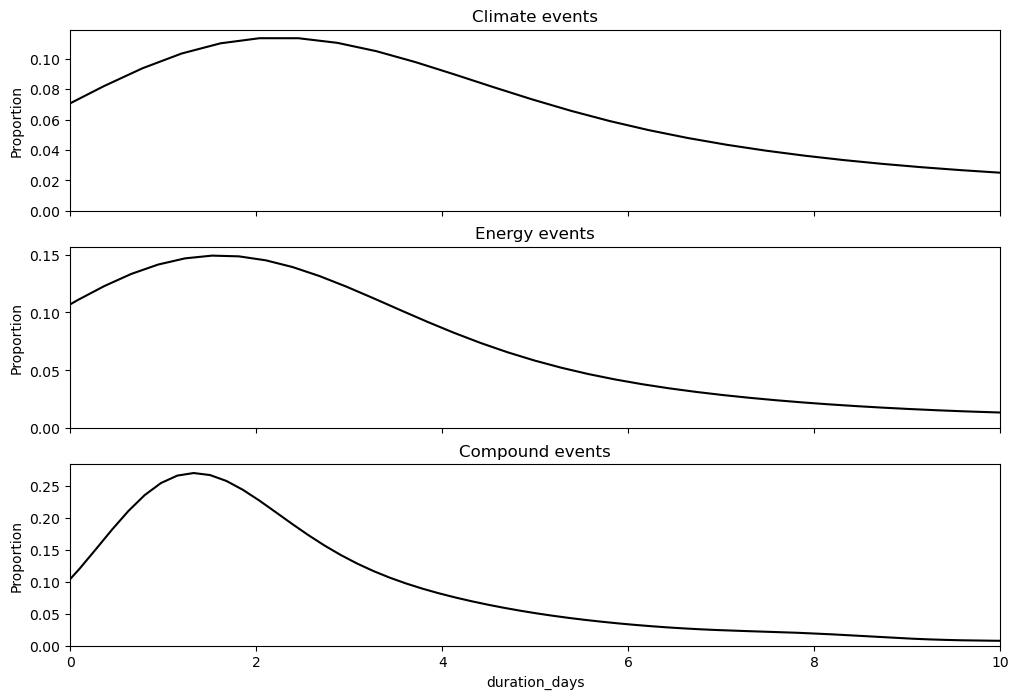

In [10]:
fig, axs = plt.subplots(3, figsize = [12, 8], sharex = True) # TODO: Rolling mean
for i, e in enumerate([climate_events, energy_events, compound_events]):
    e["duration_days"] = e["duration"].astype(int) * 1e-9 / 3600 / 24
    for scenario in e.scenario.unique():
        for model in e.model.unique():
            e2plot = e[(e.scenario == scenario) & (e.model == model)].set_index("year")
            sns.kdeplot(data=e2plot, x= "duration_days", c = scenario_colors[scenario], ax = axs[i], 
                        linestyle = model_linestyles[model], warn_singular=False)
    axs[i].set_ylabel("Proportion")
axs[0].set_title("Climate events")
axs[1].set_title("Energy events")
axs[2].set_title("Compound events")
axs[0].set_xlim(0, 10)

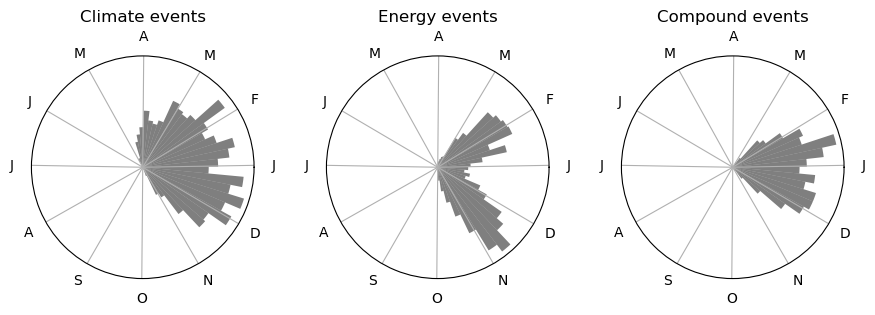

In [11]:
doy_first_day_month = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]

fig, axs = plt.subplots(1, 3, subplot_kw = dict(projection = "polar"), figsize = (9,3))
for i, e in enumerate([climate_events, energy_events, compound_events]):
    e["doy"] = e["start"].dt.dayofyear
    for scenario in e.scenario.unique():
        for model in e.model.unique():
            e2plot = e[(e.scenario == scenario) & (e.model == model)].set_index("year")
            H = np.histogram(e2plot.doy, bins = np.arange(0.5,366+1,6))
            H_theta = H[1] * 2 * np.pi / 366
            theta_mid = (H_theta[:-1] + H_theta[1:]) / 2
            width = H_theta[1] - H_theta[0]
            axs[i].bar(theta_mid, H[0], width = width, bottom = 0, alpha = 0.5, 
                       color = scenario_colors[scenario],)
    axs[i].set_xticks(np.array(doy_first_day_month) * 2 * np.pi / 366, 'JFMAMJJASOND')
    axs[i].set_yticks([])
axs[0].set_title("Climate events")
axs[1].set_title("Energy events")
axs[2].set_title("Compound events")

plt.tight_layout()